In [1]:
#!pip3 install boto3

In [30]:
boto3.__version__

'1.17.27'

https://docs.aws.amazon.com/rekognition/latest/dg/images.html

In [75]:
import base64
import boto3
import json
import time
from PIL import Image, ImageDraw
import io

from collections import namedtuple

Box = namedtuple("Box", "y_min x_min y_max x_max")

RED = (255, 0, 0)  # For objects within the ROI

import base64
import boto3
import json
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from typing import Tuple

from PIL import Image, ImageDraw, UnidentifiedImageError

RED = (255, 0, 0)  # For objects within the ROI
GREEN = (0, 255, 0)  # For ROI box
YELLOW = (255, 255, 0)  # For objects outside the ROI

def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.

    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.

    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 3
    font_height = 8
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text(
            (left + line_width, abs(top - line_width - font_height)), text, fill=color
        )

def image_to_byte_array(image : Image) -> bytes:
    """Convert pil image to bytes"""
    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format='png')
    imgByteArr = imgByteArr.getvalue()
    return imgByteArr

In [3]:
ls *

annotated.jpg       gasmeter.png       rekognition-text.ipynb
annotated-text.jpg  people_car.jpg     smart_meter.jpg
annotated-text.png  rekognition.ipynb


In [4]:
FIG_SIZE = (20, 12)
image_file='gasmeter.png'

REGION='us-west-2'
client=boto3.client('rekognition', region_name=REGION)

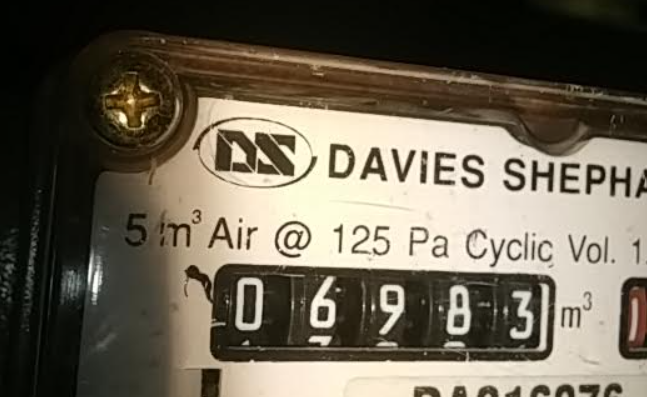

In [49]:
img = Image.open(image_file)
img

In [50]:
y_min = 0.7 # top
x_min = 0.35 # left
y_max = 0.9 # bottom
x_max = 0.83 # right

box = Box(y_min, x_min, y_max, x_max)

In [51]:
draw = ImageDraw.Draw(img)

draw_box(
    draw,
    box,
    img.width,
    img.height,
    color=RED,
    )

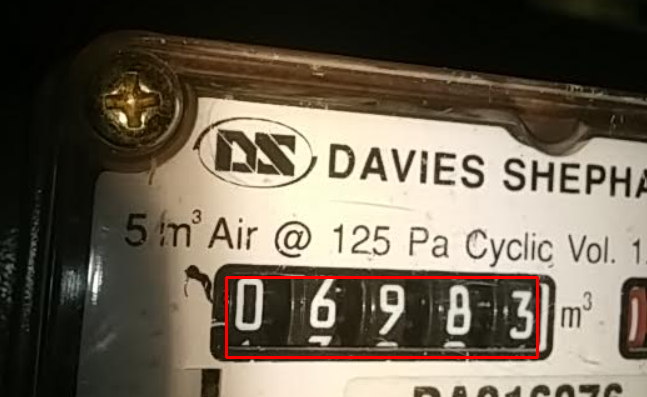

In [52]:
img.save("annotated-text.png",)
Image.open("annotated-text.png")

In [53]:
# img = Image.open(image_file).convert("RGB")
# img.shape

In [54]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [59]:
img_width, img_height = img.size

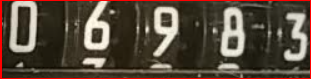

In [66]:
# these are pixel coords
(left, upper, right, lower) = (x_min*img_width, y_min*img_height, x_max*img_width, y_max*img_height)
img_crop = img.crop((left, upper, right, lower))

img_crop.save("cropped-text.png",)
img_crop

In [77]:
response = client.detect_text(Image={'Bytes': image_to_byte_array(img_crop)})

In [81]:
detected_text = [t['DetectedText'] for t in response['TextDetections'] if t["Type"] == "WORD"]

"".join(detected_text).replace(" ", "")

'06983'

## Text
https://docs.aws.amazon.com/rekognition/latest/dg/text-detecting-text-procedure.html

In [62]:
%%time

image_file = "cropped-text.png"
with open(image_file, 'rb') as image:
    try:
        response = client.detect_text(Image={'Bytes': image.read()})
    except Exception as exc:
        print(exc)

CPU times: user 18.5 ms, sys: 4.57 ms, total: 23.1 ms
Wall time: 2.56 s


In [63]:
response['TextDetections']

[{'DetectedText': '06983',
  'Type': 'LINE',
  'Id': 0,
  'Confidence': 96.7950210571289,
  'Geometry': {'BoundingBox': {'Width': 0.9742765426635742,
    'Height': 0.7722556591033936,
    'Left': 0.022508038207888603,
    'Top': 0.0},
   'Polygon': [{'X': 0.022508038207888603, 'Y': 0.0},
    {'X': 0.9967845678329468, 'Y': 0.0},
    {'X': 0.9967845678329468, 'Y': 0.7722556591033936},
    {'X': 0.022508038207888603, 'Y': 0.7722556591033936}]}},
 {'DetectedText': '06983',
  'Type': 'WORD',
  'Id': 1,
  'ParentId': 0,
  'Confidence': 96.7950210571289,
  'Geometry': {'BoundingBox': {'Width': 0.9742765426635742,
    'Height': 0.7722556591033936,
    'Left': 0.022508038207888603,
    'Top': 0.0},
   'Polygon': [{'X': 0.022508038207888603, 'Y': 0.0},
    {'X': 0.9967845678329468, 'Y': 0.0},
    {'X': 0.9967845678329468, 'Y': 0.7722556591033936},
    {'X': 0.022508038207888603, 'Y': 0.7722556591033936}]}}]

In [64]:
[t['DetectedText'] for t in response['TextDetections']]

['06983', '06983']

Has picked up the number plate but with incorrect 8 as a B

## Filters
Can filter with ROI: Limits detection to a specific region of the image frame. The values are relative to the frame's dimensions. For text only partially within a region, the response is undefined.

In [11]:
# left = 0
# top = 0
# height = 1
# width = 0.34

with open(image_file, 'rb') as image:
    try:
        response = client.detect_text(
            Image={'Bytes': image.read()},
            Filters={'RegionsOfInterest': [
                {'BoundingBox': {
                    'Height': y_max, 
                    'Left': x_min, 
                    'Top': y_min, 
                    'Width': x_max
                }}]
                    })
    except Exception as exc:
        print(exc)

In [29]:
# response['TextDetections']

In [27]:
[t['DetectedText'] for t in response['TextDetections']]

['0 6 9 B 3 m3', '0', '6', '9', 'B', '3', 'm3']

In [22]:
my_text = ''.join([t['DetectedText'] for t in response['TextDetections'] if t['Type'] == 'LINE'])
my_text

'0 6 9 B 3 m3'

Strip whitepsace and keep chars

In [24]:
keep_chars = 5
my_text = my_text.replace(" ", "")[:keep_chars]
my_text

'069B3'

In [26]:
float(my_text.replace('B', '8'))

6983.0